In [56]:
import numpy as np
import torch
from torch import nn
import cv2
import kornia
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '../research_pipelines/denoising_with_fourier/FFTCNN/')
from torch_resample import resample

%matplotlib inline

In [57]:
def read_image(_imgp):
    _img = cv2.imread(_imgp, cv2.IMREAD_COLOR)
    _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
    return _img


def retrieve_elements_from_indices(tensor, indices):
    flattened_tensor = tensor.flatten(start_dim=2)
    output = flattened_tensor.gather(dim=2, index=indices.flatten(start_dim=2)).view_as(indices)
    return output


class FFTMaxPool(nn.Module):
    def __init__(self, k: int = 2):
        super().__init__()
        self.k = k

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        x = torch.abs(z)
        _, indices = nn.functional.max_pool2d_with_indices(x, kernel_size=self.k)
        new_y = retrieve_elements_from_indices(z, indices)

        return new_y, indices
    
    
class FFTUnpool(nn.Module):
    def __init__(self, k: int = 2) -> None:
        super().__init__()
        self.k = k

    def forward(self, x, indices):
        x_re = x.real
        x_im = x.imag
        
        new_y_re = nn.functional.max_unpool2d(x_re, indices, self.k)
        new_y_im = nn.functional.max_unpool2d(x_im, indices, self.k)
        
        return new_y_re + 1.0j * new_y_im
    
    
class FFTDownsample(nn.Module):
    def __init__(self, k: int = 2) -> None:
        super().__init__()
        self.k = k

    def forward(self, z):
        new_y = z[:, :, ::self.k, ::self.k]
        return new_y
    
    
class FFTUpsample(nn.Module):
    def __init__(self, k: int = 2) -> None:
        super().__init__()
        self.k = k

    def forward(self, x):
        h_in, w_in = x.size(2), x.size(3)
        h = h_in * self.k
        w = w_in * self.k
        
        new_y = torch.zeros(x.size(0), x.size(1), h, w, dtype=x.dtype, device=x.device)
        
        new_y[:, :, ::self.k, ::self.k] = x
        
        return new_y
    

def generate_batt(size=(5, 5), d0=5, n=2):
    kernel = np.fromfunction(
        lambda x, y: \
            1 / (1 + (((x - size[0] // 2) ** 2 + (
                    y - size[1] // 2) ** 2) ** 1 / 2) / d0) ** n,
        (size[0], size[1])
    )
    return kernel

    
class HightFrequencyImageComponent(nn.Module):
    def __init__(self, shape, four_normalized=True):
        super().__init__()

        self.four_normalized = four_normalized
        kernel = 1.0 - generate_batt(shape, 500, 1).astype(np.float32)
        self.image_shape = shape

        kernel = torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0)
        kernel = kernel.to(torch.cfloat)
        
        self.kernel = nn.Parameter(kernel, requires_grad=False)

    def apply_fft_kernel(self, x):
        return x*self.kernel[:, -x.size(2):]

    def forward(self, z):
        n_fourier_transform_x = self.apply_fft_kernel(
            torch.fft.fftshift(z)
        )
        return torch.fft.ifftshift(n_fourier_transform_x)
    
    
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]], dtype=np.float32)
    _ycbcr = im.dot(xform.T)
    _ycbcr[:,:,[1,2]] += 128 / 255.0
    return _ycbcr


def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]], dtype=np.float32)
    _rgb = im.astype(np.float32)
    _rgb[:,:,[1,2]] -= 128 / 255.0
    _rgb = _rgb.dot(xform.T)
    return _rgb


class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

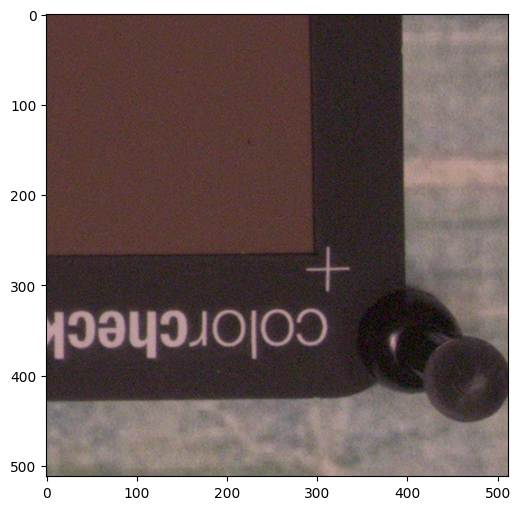

In [141]:
# image_path = '/home/alexey/Downloads/image1.jpg'
image_path = '../materials/sony_a7c_5_crop.png'
image = read_image(image_path)
l_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)[..., 0]

plt.figure(figsize=(8, 6))
plt.imshow(image, 'gray')

plt.show()

In [142]:
rgb = torch.from_numpy(read_image(image_path).astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0)

ycrcbt = kornia.color.ycbcr.rgb_to_ycbcr(rgb)
rgb_t = kornia.color.ycbcr.ycbcr_to_rgb(ycrcbt)

print((rgb_t - rgb).mean())

# plt.figure(figsize=(8, 6))
# plt.imshow(rgb2, 'gray')

# plt.show()

tensor(8.9576e-06)


214.66998882703325


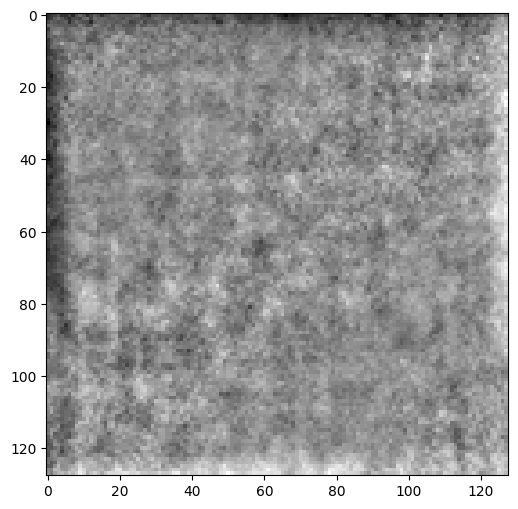

In [148]:
img_fft = np.fft.fft2(l_image - 0.5).astype(np.cfloat)
t_tensor = torch.from_numpy(img_fft).to(torch.cfloat)
t_tensor = t_tensor.unsqueeze(0).unsqueeze(0)

t_tensor = HightFrequencyImageComponent((l_image.shape[:2]))(t_tensor)

downscale_t, indices = FFTMaxPool(4)(t_tensor)
downscale_img_fft = downscale_t.squeeze(0).squeeze(0).numpy()
downscale_image = np.fft.ifft2(downscale_img_fft)
downscale_image = downscale_image.real + 0.5
print(downscale_image.max())

plt.figure(figsize=(8, 6))
plt.imshow(downscale_image, 'gray')

plt.show()

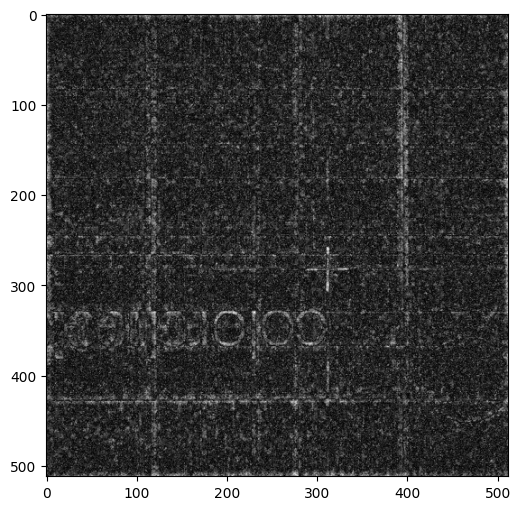

In [149]:
t_tensor = torch.clone(downscale_t).to(torch.cfloat)

upscale_t = FFTUnpool(4)(t_tensor, indices)
upscale_img_fft = upscale_t.squeeze(0).squeeze(0).numpy()
upscale_image = np.abs(np.fft.ifft2(upscale_img_fft))

plt.figure(figsize=(8, 6))
plt.imshow(upscale_image, 'gray')

plt.show()

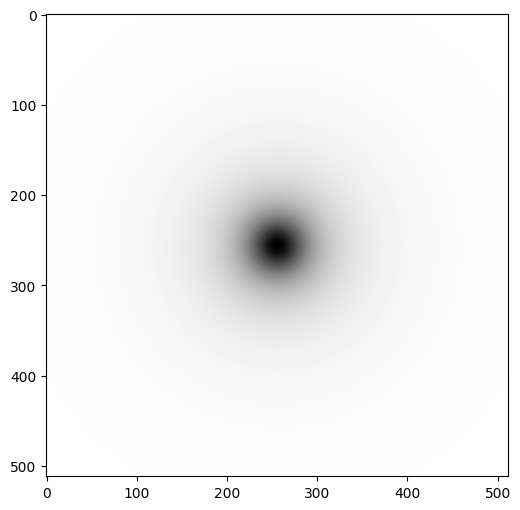

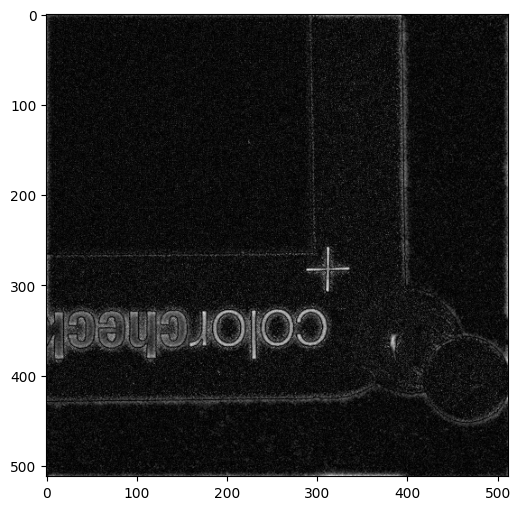

In [150]:
hf = HightFrequencyImageComponent((l_image.shape[:2]))

img_fft = np.fft.fft2(l_image)
t_tensor = torch.from_numpy(img_fft)
t_tensor = t_tensor.unsqueeze(0).unsqueeze(0)

f_tensor = hf(t_tensor)

filteted_img_fft = f_tensor.squeeze(0).squeeze(0).numpy()
filteted_image = np.abs(np.fft.ifft2(filteted_img_fft))


plt.figure(figsize=(8, 6))
plt.imshow(torch.abs(hf.kernel[0, 0]), 'gray')

plt.figure(figsize=(8, 6))
plt.imshow(filteted_image, 'gray')

plt.show()

In [151]:
rgb_tensor = torch.from_numpy(image[:512].astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0)
rgb_tensor.shape

torch.Size([1, 3, 512, 512])

torch.Size([1, 3, 8, 8, 64, 64])
torch.Size([1, 192, 4096])


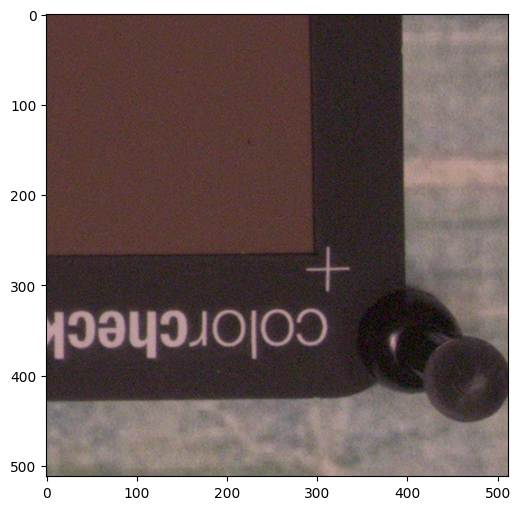

In [152]:
path_size = 64

p = rgb_tensor.unfold(2, size=path_size, step=path_size).unfold(3, path_size, step=path_size).contiguous()

fftp = torch.fft.fft2(p)
fftp = torch.fft.fftshift(fftp)

init_p_shape = p.shape

print(init_p_shape)

p = p.view(
    p.size(0), 
    p.size(1) * p.size(2) * p.size(3),
    p.size(4) * p.size(5)
)

print(p.shape)

sattn = SelfAttention(path_size ** 2)

# out = sattn(p)
out = p

out = out.view(*init_p_shape)

out = torch.cat([out[:, :, :, i] for i in range(out.size(3))], dim=4)
out = torch.cat([out[:, :, i] for i in range(out.size(2))], dim=2)

# print(out.shape)

plt.figure(figsize=(8, 6))
plt.imshow(out.detach()[0].permute(1, 2, 0).numpy().clip(0, 1))

plt.show()

In [114]:
llayer = nn.Linear(1024, 64)

llayer(torch.rand(1, 384, 1024)).shape

torch.Size([1, 384, 64])

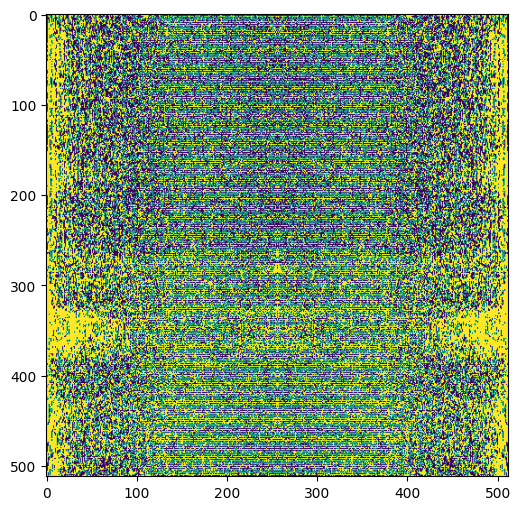

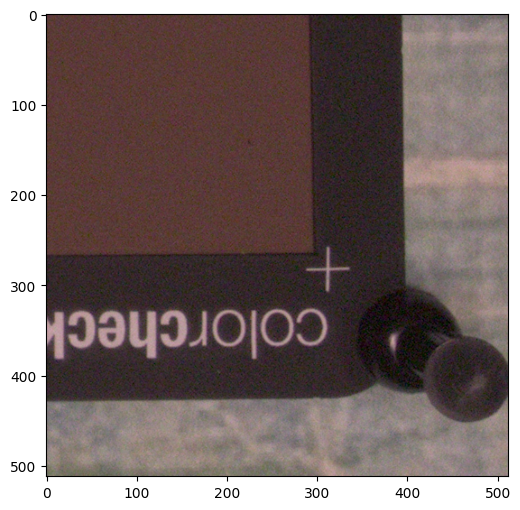

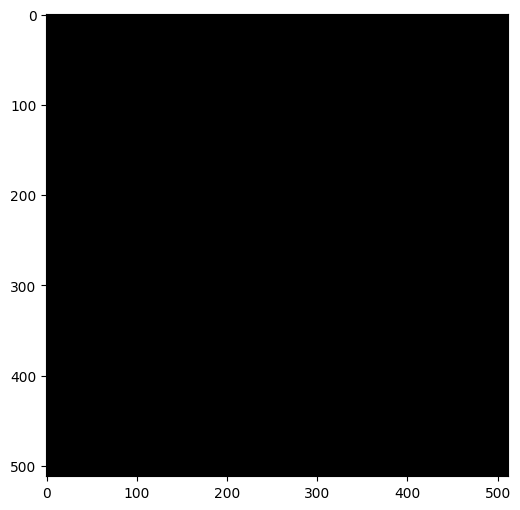

In [153]:
z = torch.fft.fft(rgb_tensor)

_, max_indices = torch.max(torch.abs(z), dim=1, keepdim=True)
max_z = retrieve_elements_from_indices(z, max_indices)

# max_z = torch.mean(z, dim=1, keepdim=True)

plt.figure(figsize=(8, 6))
plt.imshow(torch.abs(torch.sigmoid(max_z))[0].permute(1, 2, 0).numpy().clip(0, 1))

max_z = z * torch.sigmoid(max_z)

rev_rgb_ternsor = torch.fft.ifft(max_z).real

plt.figure(figsize=(8, 6))
plt.imshow(rev_rgb_ternsor[0].permute(1, 2, 0).numpy().clip(0, 1))

plt.figure(figsize=(8, 6))
plt.imshow(
    torch.abs(rev_rgb_ternsor - rgb_tensor)[0].permute(
        1, 2, 0).numpy().clip(0, 1)
)

plt.show()

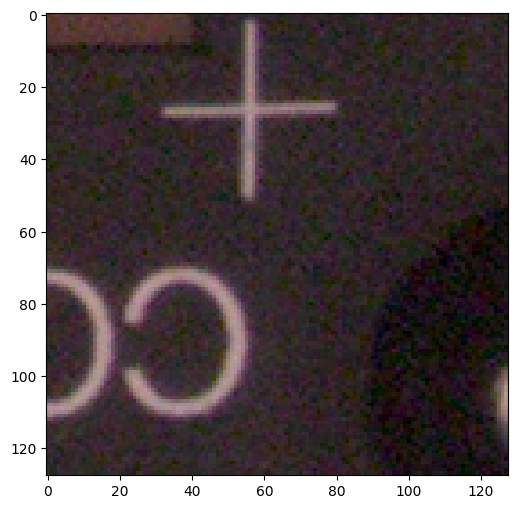

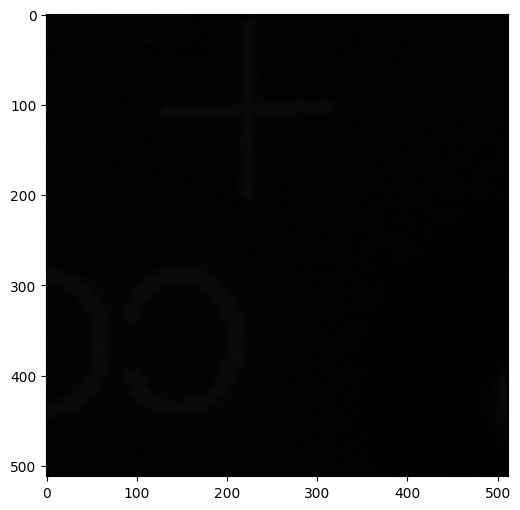

In [179]:
crop = rgb_tensor[:, :, 256:256 + 128, 256:256 + 128]

z = torch.fft.fft2(crop)
z = torch.fft.fftshift(z)

full_z = torch.zeros(*rgb_tensor.shape, dtype=torch.cfloat)

full_z[:, :, 512 // 2 - 64:512 // 2 + 64, 512 // 2 - 64:512 // 2 + 64] = z

full_z = torch.fft.ifftshift(full_z)

rgb_from_crop = torch.fft.ifft2(full_z).real

plt.figure(figsize=(8, 6))
plt.imshow(crop[0].permute(1, 2, 0).numpy().clip(0, 1))

plt.figure(figsize=(8, 6))
plt.imshow(rgb_from_crop[0].permute(1, 2, 0).numpy().clip(0, 1))

plt.show()